In [2]:
import sys
import os                 # for basic operating system functions
import json
import rasterio
import warnings
import configparser
import contextily as cx
import geopandas as gpd   # For working with geospatial dataframes
import matplotlib.pyplot as plt
import pandas as pd       # To load .csv data as a dataframe
import seaborn as sns
from rasterio.mask import mask
#from rasterstats import zonal_stats
from shapely.geometry import MultiPolygon
warnings.filterwarnings('ignore')

In [3]:
metadata_file = os.path.join('data', 'raw', 'countries.csv')
countries = pd.read_csv(metadata_file, encoding = 'latin-1')
countries

,iso3,iso2,country,continent,gid_region,lowest,Exclude,Population,income_group,flood_region
0,ABW,AW,Aruba,North America,0,0,1,"107,195",HIC,South America
1,AFG,AF,Afghanistan,Asia,2,2,0,"39,835,428",LIC,South Asia
2,AGO,AO,Angola,Africa,2,2,0,"33,933,611",LMC,Sub-Saharan Africa
3,AIA,AI,Anguilla,North America,0,0,1,-,-,Central America & Caribbean
4,ALA,AX,Åland Islands,Europe,2,2,1,-,-,Western Europe
...,...,...,...,...,...,...,...,...,...,...
245,XKO,NaN,Kosovo,NaN,0,0,1,-,-,Western Europe
246,YEM,YE,Yemen,Asia,2,2,0,"30,490,639",LIC,Middle East & North Africa
247,ZAF,ZA,South Africa,Africa,1,2,0,"60,041,996",UMC,Sub-Saharan Africa
248,ZMB,ZM,Zambia,Africa,2,2,0,"18,920,657",LMC,Sub-Saharan Africa


process folder for a single country

In [11]:
def country_directory(csv_filename, country_iso3):
    """
    Create country folder and regions subfolder within it.
    
    Parameters
    ----------
    csv_filename : string
        Name of the country metadata file.
    country_iso3 : string
        Country iso3 to be processed.
        
    Returns
    -------
    output : list
        List containing country ISO3 and gid_region
    """
    countries = pd.read_csv(csv_filename, encoding = 'latin-1')
    
    output = []
    
    for idx, country in countries.iterrows():
        
        if not country['iso3'] == country_iso3: #If the current country iso3 does not match the entered iso3...
            continue                            #continue in the loop to the next country
            
        iso3 = country['iso3']
        gid_region = country['gid_region']
        country_name = country['country']
        
        output.append(iso3)
        output.append(gid_region)
        
        country_folder_path = os.path.join('data', 'processed', iso3) #Create folder called "processed" to store
        if not os.path.exists(country_folder_path):                   #country folder
            os.makedirs(country_folder_path)                          #Onle create folder if it doest exist already
            
        regions_folder_path = os.path.join('data', 'processed', iso3, 'regions') #Create regions folder within
        if not os.path.exists(regions_folder_path):
            os.makedirs(regions_folder_path)
            
        print('processing {}'.format(country_name))      
    
    return output

In [28]:
country_directory(metadata_file, 'RWA')

processing Rwanda


['RWA', 1]

In [74]:
def country_boundary(boundary_data_path, country_iso3):
    """
    Process country shapefile.
    
    Parameters
    ----------
    boundary_data_path : string
        Location of the GADM boundary data.
    country_iso3 : string
        Country iso3 to be processed.
    gid_level: string
        GID boundary spatial level to process
        
    Returns
    -------
    none  
    """
    global_boundaries = gpd.read_file(boundary_data_path)
    
    iso3 = country_directory(metadata_file, country_iso3)[0]
    gid_region = country_directory(metadata_file, country_iso3)[1]
    
    country_boundaries = global_boundaries[global_boundaries['GID_0'] == iso3]
    gid_level_name = country_boundaries['NAME_1']
    
    filename = 'gadm_{}.shp'.format(gid_region)
    path_out = os.path.join('data', 'processed', iso3, 'regions', filename)
    country_boundaries.to_file(path_out)
    
    print('processing {}'.format(gid_level_name))
    
    return None

Process country shapefile

In [78]:
country_level = country_directory(metadata_file, 'RWA')

processing Rwanda


In [79]:
boundary_data = os.path.join('data', 'raw', 'gadm36_{}.shp'.format(country_level[1])) 

In [80]:
country_boundary(boundary_data, 'RWA')

processing Rwanda
processing Rwanda
processing 2688        Amajyaruguru
2689           Amajyepfo
2690       Iburasirazuba
2691      Iburengerazuba
2692    Umujyi wa Kigali
Name: NAME_1, dtype: object


In [4]:
filename = 'ppp_2020_1km_Aggregated.tif'
folder = os.path.join('data', 'raw', 'worldpop')
path_population = os.path.join(folder, filename)

my_raster_image = rasterio.open(path_population)
my_raster_image

<open DatasetReader name='data/raw/worldpop/ppp_2020_1km_Aggregated.tif' mode='r'>

Processed Rwanda Country Boundaries

In [5]:
path_boundary = os.path.join('data', 'processed', 'RWA', 'regions', 'gadm_{}.shp'.format(country_level[1]))
boundaries = gpd.read_file(path_boundary, crs = 'epsg:4326')
boundaries

NameError: name 'country_level' is not defined

In [87]:
def process_population_tif(data_name, grid_level):
    """
    Process population layer.
    
    Parameters
    ----------
    data_name: string
        Filename of the population raster layer
    gid_level: string
        GID boundary spatial level to process
        
    Returns
    -------
    output: dictionary.
        Dictionary containing the country population and grid level
    """
    output = []
    for idx, boundary in boundaries.iterrows():
        
        print('Working on {}'.format(boundary['NAME_1']))
        
        with rasterio.open(data_name) as src:
            
            affine = src.transform
            array = src.read(1)
            array[array <= 0] = 0
            
            population = [i['sum'] for i in zonal_stats(
                boundary['geometry'], array, nodata = 255,
                stats = ['sum'], affine = affine)][0]
            output.append({
                'NAME_1': boundary['NAME_1'],
                'GID_1': boundary[grid_level],
                'population': population
            })
            
    return output

In [88]:
pop = process_population_tif(path_population, 'GID_1')

Working on Amajyaruguru
Working on Amajyepfo
Working on Iburasirazuba
Working on Iburengerazuba
Working on Umujyi wa Kigali


Save the processed population data into csv

In [89]:
pop_results = pd.DataFrame(pop)
path_out = os.path.join('data', 'processed', 'RWA', 'population.csv')
pop_results.to_csv(path_out)

In [105]:
def plot_population(country_boundaries, csv_data, gid_level, iso3):
    """
    Plots the country's population at sub-region level.
    
    Parameters
    ----------
    country_boundaries : string
        Name of the country boundary .shp file
    csv_data : string
        Name of the csv file containing the population data
        at sub-regional level
    gid_level : string
        Name of the GID level
    country_iso3 = string
        ISO3 of the country
    
    Return
    ------
    fig : python object
        A map of population distribution. 
    """
    boundaries = country_boundaries.merge(csv_data, left_on = gid_level, #merge our population data onto our boundaries
                                  right_on = gid_level)
    
    bins = [-1e6, 1600000, 1900000, 2500000, 2900000, 3500000, 3800000, 4000000]
    labels = ['<1.6M','1.6-1.9M','1.9-2.5M','2.5-2.9M', '2.9-3.5M', '3.5-3.8M', '3.8-4M']
     
    boundaries['bin'] = pd.cut(                                   #create a new variable with our bin labels
        boundaries['population'], 
        bins = bins,
        labels = labels
    )   
    
    sns.set(font_scale = 0.9)                                     #open a new seaborn figure
    fig, ax = plt.subplots(1, 1, figsize = (8, 8))

    base = boundaries.plot(column = 'bin', ax = ax,               #now plot our data using pandas plot
                           cmap = 'copper', linewidth = 0, 
                           legend = True, antialiased = False)
    #allocate a plot title 
    n = len(boundaries)
    name = 'Rwanda Population by Sub-Region(n={})'.format(n)
    fig.suptitle(name)
    
    path = os.path.join('data', 'processed', iso3, '{}_population.png'.format(iso3))
    fig.savefig(path)
    plt.close(fig)

    fig
    
    return fig

In [106]:
#import our population data
filename = 'population.csv'
path_in = os.path.join('data', 'processed', 'RWA', filename) 
data = pd.read_csv(path_in)

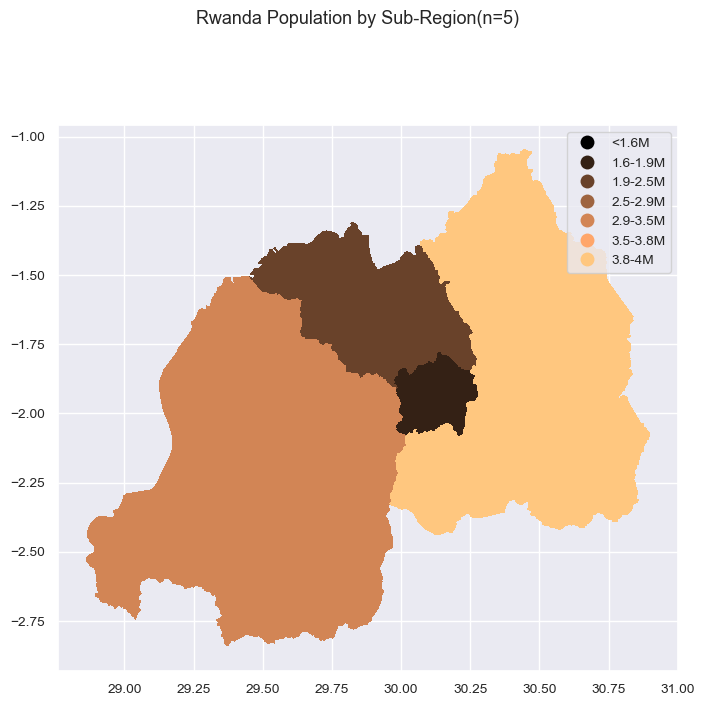

In [107]:
plot_population(boundaries, data, 'GID_1', 'RWA')

### Processing Flooding Data 

In [6]:
for idx, country in countries.iterrows():

    if not country['iso3'] == 'RWA': 
        continue   
    
    #define our country-specific parameters, including gid information
    iso3 = country['iso3']
    gid_region = country['gid_region']
    gid_level = 'GID_{}'.format(gid_region)
    
    #set the filename depending our preferred regional level
    filename = "gadm_{}.shp".format(gid_region)
    folder = os.path.join('data','processed', iso3, 'regions')
    
    #then load in our regions as a geodataframe
    path_regions = os.path.join(folder, filename)
    regions = gpd.read_file(path_regions, crs = 'epsg:4326')#[:2]
    
    for idx, region in regions.iterrows():

        #get our gid id for this region 
        #(which depends on the country-specific gid level)
        gid_id = region[gid_level]
        
        print('----Working on {}'.format(gid_id))
        
        #let's load in our hazard layer
        filename = 'inunriver_rcp8p5_0000HadGEM2-ES_2080_rp00100.tif'
        path_hazard = os.path.join('data','raw','flood_hazard', filename)
        hazard = rasterio.open(path_hazard, 'r+')
        hazard.nodata = 255                       #set the no data value
        hazard.crs.from_epsg(4326)                #set the crs

        #create a new gpd dataframe from our single region geometry
        geo = gpd.GeoDataFrame(gpd.GeoSeries(region.geometry))
        #this line sets geometry for resulting geodataframe
        geo = geo.rename(columns = {0:'geometry'}).set_geometry('geometry')
        #convert to json
        coords = [json.loads(geo.to_json())['features'][0]['geometry']] 
        
        #carry out the clip using our mask
        out_img, out_transform = mask(hazard, coords, crop = True)
        out_img, out_transform

        #update our metadata
        out_meta = hazard.meta.copy()
        out_meta.update({"driver": "GTiff",
                        "height": out_img.shape[1],
                        "width": out_img.shape[2],
                        "transform": out_transform,
                        "crs": 'epsg:4326'})

        #now we write out at the regional level
        filename_out = '{}.tif'.format(gid_id) #each regional file is named using the gid id
        folder_out = os.path.join('data', 'processed', 'RWA', 'hazards', 'inunriver', 'tifs')
        if not os.path.exists(folder_out):
            os.makedirs(folder_out)
        path_out = os.path.join(folder_out, filename_out)

        with rasterio.open(path_out, "w", **out_meta) as dest:
            dest.write(out_img)
    print('--')
    print('Processing complete for {}'.format(iso3))

----Working on RWA.1_1
----Working on RWA.2_1
----Working on RWA.3_1
----Working on RWA.4_1
----Working on RWA.5_1
--
Processing complete for RWA


In [7]:
folder = os.path.join('data', 'processed', 'RWA', 'hazards', 'inunriver', 'tifs') #Folder location
lists = os.listdir(folder) 
for tifs in os.listdir(folder):
    if tifs.endswith('.tif'):
        tifs = os.path.splitext(tifs)[0]

In [8]:
for tifs in os.listdir(folder):
    try:
        if tifs.endswith('.tif'):
            tifs = os.path.splitext(tifs)[0]

            folder = os.path.join('data', 'processed', 'RWA', 'hazards', 'inunriver', 'tifs')
            filename = tifs + '.tif'
            
            path_in = os.path.join(folder, filename)

            folder = os.path.join('data', 'processed', 'RWA', 'hazards', 'inunriver', 'shapefiles')
            if not os.path.exists(folder):
                os.mkdir(folder)
                
            filename = tifs + '.shp'
            path_out = os.path.join(folder, filename)

            with rasterio.open(path_in) as src:

                affine = src.transform
                array = src.read(1)

                output = []

                for vec in rasterio.features.shapes(array):

                    if vec[1] > 0 and not vec[1] == 255:

                        coordinates = [i for i in vec[0]['coordinates'][0]]

                        coords = []

                        for i in coordinates:

                            x = i[0]
                            y = i[1]

                            x2, y2 = src.transform * (x, y)

                            coords.append((x2, y2))

                        output.append({
                            'type': vec[0]['type'],
                            'geometry': {
                                'type': 'Polygon',
                                'coordinates': [coords],
                            },
                            'properties': {
                                'value': vec[1],
                            }
                        })

            output = gpd.GeoDataFrame.from_features(output, crs = 'epsg:4326')
            output.to_file(path_out, driver = 'ESRI Shapefile')
    except:
        pass

In [11]:
folder = os.path.join('data', 'processed', 'RWA', 'hazards', 'inunriver', 'shapefiles')

# Create an empty geodataframe to hold the combined data
combined_gdf = gpd.GeoDataFrame(crs = 'epsg:4326')

for shapefiles in os.listdir(folder):
    
    if shapefiles.endswith('.shp'):
        
        filepath = os.path.join(folder, shapefiles)
        
        # Read the shapefile and add it to the combined dataframe
        gdf = gpd.read_file(filepath)
        combined_gdf = combined_gdf.append(gdf, ignore_index = True)

In [12]:
combined_gdf

,value,geometry
0,0.160089,"POLYGON ((29.65833 -1.73333, 29.66667 -1.73333..."
1,0.160089,"POLYGON ((29.69167 -1.73333, 29.70000 -1.73333..."
2,0.160089,"POLYGON ((29.65833 -1.75000, 29.66667 -1.75000..."
3,0.160089,"POLYGON ((29.70833 -1.75000, 29.71667 -1.75000..."
4,0.160089,"POLYGON ((29.74167 -1.75000, 29.75000 -1.75000..."
...,...,...
450,0.649345,"POLYGON ((30.05833 -2.05833, 30.07500 -2.05833..."
451,0.649345,"POLYGON ((30.21667 -2.05833, 30.22500 -2.05833..."
452,0.665803,"POLYGON ((30.00833 -2.06667, 30.01667 -2.06667..."
453,0.649345,"POLYGON ((30.01667 -2.06667, 30.02500 -2.06667..."


IndexError: list index out of range

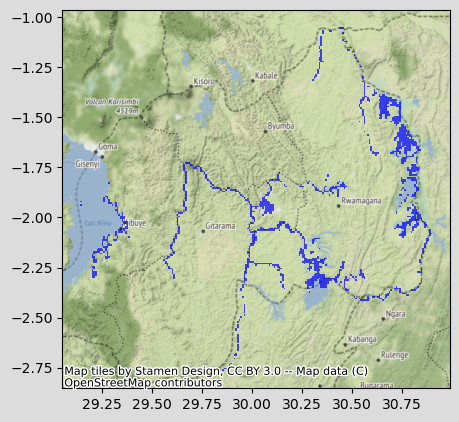

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 6)) 
fig.set_facecolor('gainsboro')

# Import hazard and plot 
hazard = combined_gdf
hazard.plot(color = 'blue', linewidth = 1.5, alpha = .7, legend = True, edgecolor = None, ax = ax)

cx.add_basemap(ax, crs = 'epsg:4326') #add the map baselayer

# Subset scenario strings for title
hazard_type = filename.split('_')[0]
scenario = filename.split('_')[1]
model = filename.split('_')[2]
year = filename.split('_')[3]
return_period = filename.split('_')[4]
return_period = return_period.replace('.shp', '')

# Insert scenario strings in title
main_title = 'Projected River Flooding:\n{}, {}, {}, {}, {}, {}'.format(
    'RWA', hazard_type, scenario, model, year, return_period
)
plt.suptitle(main_title, fontsize = 13, wrap = True)

path = os.path.join('data', 'processed', iso3, main_title)
fig.savefig(path)
plt.close(fig)
fig